In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import joblib
import warnings
import os
np.random.seed(42)

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")

print("\nRatings Dataset:")
display(ratings.head())

print("\nMovies Dataset:")
display(movies.head())

Ratings: (100836, 4)
Movies: (9742, 3)

Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
print("Ratings Statistics:")
display(ratings.describe())

print("\nDataset Summary:")
print(f"Total ratings: {len(ratings):,}")
print(f"Total users: {ratings['userId'].nunique():,}")
print(f"Total movies: {ratings['movieId'].nunique():,}")
print(f"Total movies in catalog: {len(movies):,}")
print(f"Rating scale: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")
print(f"Sparsity: {(1 - len(ratings) / (ratings['userId'].nunique() * ratings['movieId'].nunique())) * 100:.2f}%")

Ratings Statistics:


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09



Dataset Summary:
Total ratings: 100,836
Total users: 610
Total movies: 9,724
Total movies in catalog: 9,742
Rating scale: 0.5 - 5.0
Average rating: 3.50
Sparsity: 98.30%


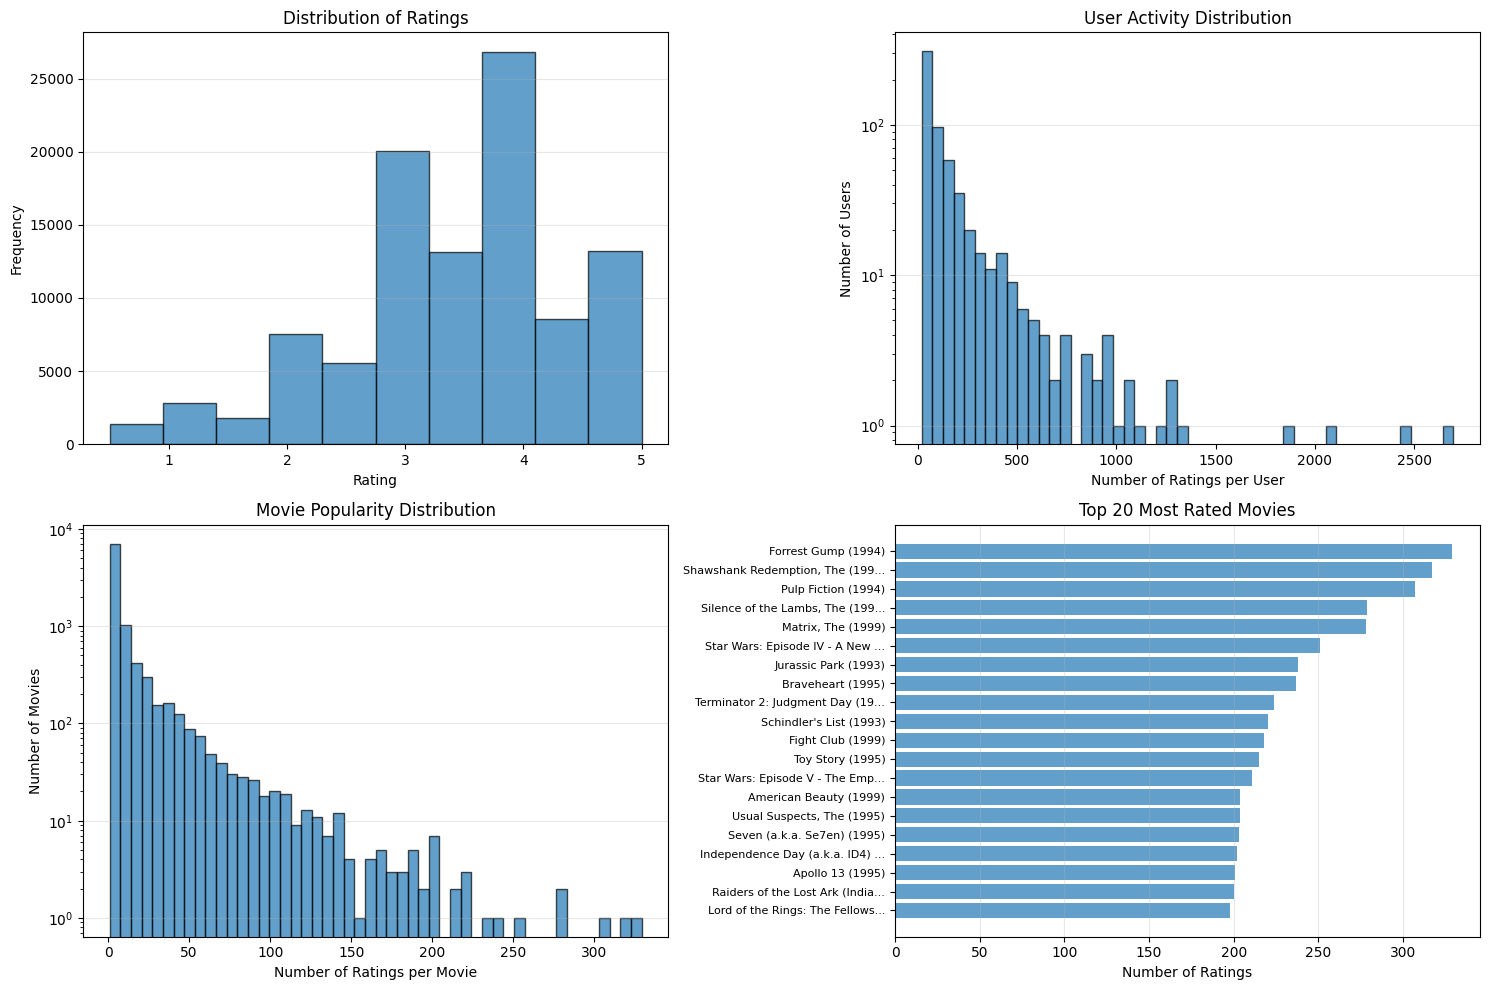

Mean ratings per user: 165.3
Median ratings per user: 70.5
Mean ratings per movie: 10.4
Median ratings per movie: 3.0


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#Rating distribution
axes[0, 0].hist(ratings['rating'], bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Ratings')
axes[0, 0].grid(axis='y', alpha=0.3)

#User activity distribution
user_activity = ratings.groupby('userId').size()
axes[0, 1].hist(user_activity, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Ratings per User')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(axis='y', alpha=0.3)

#Movie popularity distribution
movie_popularity = ratings.groupby('movieId').size()
axes[1, 0].hist(movie_popularity, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Ratings per Movie')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_title('Movie Popularity Distribution')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(axis='y', alpha=0.3)

#Top 20 most rated movies
top_movies = ratings.groupby('movieId').size().sort_values(ascending=False).head(20)
top_movies_titles = movies.set_index('movieId').loc[top_movies.index, 'title']
axes[1, 1].barh(range(20), top_movies.values, alpha=0.7)
axes[1, 1].set_yticks(range(20))
axes[1, 1].set_yticklabels([t[:30] + '...' if len(t) > 30 else t for t in top_movies_titles], fontsize=8)
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_title('Top 20 Most Rated Movies')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean ratings per user: {user_activity.mean():.1f}")
print(f"Median ratings per user: {user_activity.median():.1f}")
print(f"Mean ratings per movie: {movie_popularity.mean():.1f}")
print(f"Median ratings per movie: {movie_popularity.median():.1f}")

In [5]:
cold_start_users = user_activity[user_activity <= 5]
cold_start_movies = movie_popularity[movie_popularity <= 1]

print(f"Users with ≤5 ratings: {len(cold_start_users)} ({len(cold_start_users)/len(user_activity)*100:.1f}%)")
print(f"Movies with ≤1 rating: {len(cold_start_movies)} ({len(cold_start_movies)/len(movie_popularity)*100:.1f}%)")

Users with ≤5 ratings: 0 (0.0%)
Movies with ≤1 rating: 3446 (35.4%)


In [6]:
# Train/test split (80/20) stratified by users

# Filter users with at least 2 ratings to allow splitting
user_counts = ratings.groupby('userId').size()
valid_users = user_counts[user_counts >= 2].index
ratings_filtered = ratings[ratings['userId'].isin(valid_users)].copy()

print(f"Users before filtering: {ratings['userId'].nunique()}")
print(f"Users after filtering (≥2 ratings): {ratings_filtered['userId'].nunique()}")
print(f"Ratings retained: {len(ratings_filtered)}")

train_list = []
test_list = []

for user_id, group in ratings_filtered.groupby('userId'):
    n_test = max(1, int(len(group) * 0.2))  # At least 1 item in test
    test_indices = np.random.choice(group.index, size=n_test, replace=False)
    train_indices = group.index.difference(test_indices)
    
    train_list.append(group.loc[train_indices])
    test_list.append(group.loc[test_indices])

train_data = pd.concat(train_list).reset_index(drop=True)
test_data = pd.concat(test_list).reset_index(drop=True)

print(f"\nTrain set: {len(train_data)}")
print(f"Test set: {len(test_data)}")
print(f"Train users: {train_data['userId'].nunique()}")
print(f"Test users: {test_data['userId'].nunique()}")

Users before filtering: 610
Users after filtering (≥2 ratings): 610
Ratings retained: 100836

Train set: 80896
Test set: 19940
Train users: 610
Test users: 610


In [7]:
# Creating user-item matrix for training data using sparse matrix
# Map user and movie IDs to continuous indices
user_ids = train_data['userId'].unique()
movie_ids = train_data['movieId'].unique()

user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
movie_id_map = {mid: idx for idx, mid in enumerate(movie_ids)}

# Reverse mappings
idx_to_user = {idx: uid for uid, idx in user_id_map.items()}
idx_to_movie = {idx: mid for mid, idx in movie_id_map.items()}

# Create sparse matrix
n_users = len(user_ids)
n_movies = len(movie_ids)

row_indices = train_data['userId'].map(user_id_map).values
col_indices = train_data['movieId'].map(movie_id_map).values
ratings_values = train_data['rating'].values

# Create user-item matrix
user_item_matrix = csr_matrix(
    (ratings_values, (row_indices, col_indices)),
    shape=(n_users, n_movies)
)


print(f"Shape: {user_item_matrix.shape}")
print(f"Total elements: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"Non-zero elements: {user_item_matrix.nnz:,}")
print(f"Sparsity: {(1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.4f}%")

Shape: (610, 8998)
Total elements: 5,488,780
Non-zero elements: 80,896
Sparsity: 98.5262%


In [8]:
# Compute item-item similarity matrix on training data
item_user_matrix = user_item_matrix.T

item_similarity = cosine_similarity(item_user_matrix, dense_output=False)

print(f"Item similarity matrix shape: {item_similarity.shape}")

Item similarity matrix shape: (8998, 8998)


In [9]:
def recommend_itembased(user_id, N=5):
    if user_id not in user_id_map:
        return []
    
    user_idx = user_id_map[user_id]
    
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        return []
    
    # Compute predictions for all unrated items
    predictions = np.zeros(n_movies)
    
    for item_idx in range(n_movies):
        if user_ratings[item_idx] > 0:
            continue
        
        # Get similarities between this item and all rated items
        similarities = item_similarity[item_idx, rated_items].toarray().flatten()
        
        ratings = user_ratings[rated_items]
        
        # weighted average
        sim_sum = np.sum(np.abs(similarities))
        if sim_sum > 0:
            predictions[item_idx] = np.dot(similarities, ratings) / sim_sum
    
    top_indices = np.argsort(predictions)[::-1][:N]
    
    recommendations = [(idx_to_movie[idx], predictions[idx]) for idx in top_indices if predictions[idx] > 0]
    
    return recommendations[:N]

recs = recommend_itembased(1, 5)
if recs:
    for i, (movie_id, score) in enumerate(recs, 1):
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"{i}. {title}")
else:
    print("No recommendations")

1. Love, Rosie (2014)
2. Lucky One, The (2012)
3. Abduction (2011)
4. Beastly (2011)
5. Before We Go (2014)


In [10]:
n_components = 50
svd_model = TruncatedSVD(n_components=n_components, random_state=42)

user_factors = svd_model.fit_transform(user_item_matrix)
item_factors = svd_model.components_.T 

print(f"User factors shape: {user_factors.shape}")
print(f"Item factors shape: {item_factors.shape}")

User factors shape: (610, 50)
Item factors shape: (8998, 50)


In [11]:
def recommend_svd(user_id, N=5):
    if user_id not in user_id_map:
        return []
    
    user_idx = user_id_map[user_id]
    
    # user's rated items to be exclude from recommendations
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    predictions = np.dot(user_factors[user_idx], item_factors.T)
    
    predictions[rated_items] = -np.inf
    
    top_indices = np.argsort(predictions)[::-1][:N]
    
    recommendations = [(idx_to_movie[idx], predictions[idx]) for idx in top_indices if predictions[idx] > -np.inf]
    
    return recommendations[:N]

recs = recommend_svd(1, 5)
if recs:
    for i, (movie_id, score) in enumerate(recs, 1):
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"{i}. {title}")
else:
    print("No recommendations")

1. Die Hard (1988)
2. Men in Black (a.k.a. MIB) (1997)
3. Star Wars: Episode VI - Return of the Jedi (1983)
4. Star Wars: Episode IV - A New Hope (1977)
5. Godfather: Part II, The (1974)


In [12]:
def recommend_hybrid(user_id, N, alpha=0.2):
    if user_id not in user_id_map:
        return []
    
    user_idx = user_id_map[user_id]
    
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        return []
    
    cf_predictions = np.zeros(n_movies)
    for item_idx in range(n_movies):
        if user_ratings[item_idx] > 0:
            continue
        similarities = item_similarity[item_idx, rated_items].toarray().flatten()
        ratings = user_ratings[rated_items]
        sim_sum = np.sum(np.abs(similarities))
        if sim_sum > 0:
            cf_predictions[item_idx] = np.dot(similarities, ratings) / sim_sum
    
    svd_predictions = np.dot(user_factors[user_idx], item_factors.T)
    
    # Normalize prediction
    if cf_predictions.max() > 0:
        cf_predictions = cf_predictions / 5.0
    if svd_predictions.max() > svd_predictions.min():
        svd_predictions = (svd_predictions - svd_predictions.min()) / (svd_predictions.max() - svd_predictions.min())
    
    hybrid_predictions = alpha * cf_predictions + (1 - alpha) * svd_predictions
    
    hybrid_predictions[rated_items] = -np.inf
    
    top_indices = np.argsort(hybrid_predictions)[::-1][:N]
    
    recommendations = [(idx_to_movie[idx], hybrid_predictions[idx]) for idx in top_indices 
                      if hybrid_predictions[idx] > -np.inf]
    
    return recommendations[:N]

recs = recommend_hybrid(1, 5)
if recs:
    for i, (movie_id, score) in enumerate(recs, 1):
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"{i}. {title}")
else:
    print("No recommendations")

1. Die Hard (1988)
2. Men in Black (a.k.a. MIB) (1997)
3. Star Wars: Episode VI - Return of the Jedi (1983)
4. Star Wars: Episode IV - A New Hope (1977)
5. Godfather: Part II, The (1974)


In [13]:
def ndcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    
    if len(relevance_scores) == 0:
        return 0.0
    
    # DCG@k
    dcg = relevance_scores[0] + np.sum(relevance_scores[1:] / np.log2(np.arange(2, len(relevance_scores) + 1)))
    
    # IDCG@k
    ideal_relevance = np.sort(relevance_scores)[::-1]
    idcg = ideal_relevance[0] + np.sum(ideal_relevance[1:] / np.log2(np.arange(2, len(ideal_relevance) + 1)))
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg


def evaluate_model_optimized(recommend_func, k=5, model_name="Model", n_sample_users=100, rating_threshold=3.5):
    test_users = test_data['userId'].unique()
    # Only evaluate users that are also in training set
    valid_test_users = [uid for uid in test_users if uid in user_id_map]
    
    if len(valid_test_users) > n_sample_users:
        sampled_users = np.random.choice(valid_test_users, size=n_sample_users, replace=False)
    else:
        sampled_users = valid_test_users
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user_id in tqdm(sampled_users, desc=f"{model_name}@{k}"):
        user_test = test_data[test_data['userId'] == user_id]
        
        relevant_items = set(user_test[user_test['rating'] >= rating_threshold]['movieId'].values)
        
        if len(relevant_items) == 0:
            continue
        
        recommendations = recommend_func(user_id, N=k)
        
        if len(recommendations) == 0:
            continue

        recommended_items = [movie_id for movie_id, _ in recommendations]
        
        hits = len(set(recommended_items) & relevant_items)
        
        # Precision@k
        precision = hits / k if k > 0 else 0
        precisions.append(precision)
        
        # Recall@k
        recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
        recalls.append(recall)
        
        # NDCG@k
        relevance_scores = [1 if item in relevant_items else 0 for item in recommended_items]
        ndcg = ndcg_at_k(relevance_scores, k)
        ndcgs.append(ndcg)
    
    results = {
        f'Precision@{k}': np.mean(precisions) if precisions else 0,
        f'Recall@{k}': np.mean(recalls) if recalls else 0,
        f'NDCG@{k}': np.mean(ndcgs) if ndcgs else 0,
        'n_users_evaluated': len(precisions)
    }
    
    print(f"Results for {model_name}@{k}:")
    for metric, value in results.items():
        if metric != 'n_users_evaluated':
            print(f"  {metric}: {value:.4f}")
    print(f"  Users evaluated: {results['n_users_evaluated']}")
    
    return results

In [14]:
# Evaluating all models for k=5 and k=10
results_dict = {}

# Evaluate for k=5
results_dict['Item-Based CF (k=5)'] = evaluate_model_optimized(
    recommend_itembased, k=5, model_name="Item-Based CF", n_sample_users=100
)

results_dict['SVD (k=5)'] = evaluate_model_optimized(
    recommend_svd, k=5, model_name="SVD", n_sample_users=100
)

results_dict['Hybrid (k=5)'] = evaluate_model_optimized(
    recommend_hybrid, k=5, model_name="Hybrid", n_sample_users=100
)

# Evaluate for k=10
results_dict['Item-Based CF (k=10)'] = evaluate_model_optimized(
    recommend_itembased, k=10, model_name="Item-Based CF", n_sample_users=100
)

results_dict['SVD (k=10)'] = evaluate_model_optimized(
    recommend_svd, k=10, model_name="SVD", n_sample_users=100
)

results_dict['Hybrid (k=10)'] = evaluate_model_optimized(
    recommend_hybrid, k=10, model_name="Hybrid", n_sample_users=100
)

Item-Based CF@5: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


Results for Item-Based CF@5:
  Precision@5: 0.0020
  Recall@5: 0.0025
  NDCG@5: 0.0043
  Users evaluated: 100


SVD@5: 100%|██████████| 100/100 [00:00<00:00, 244.33it/s]


Results for SVD@5:
  Precision@5: 0.2755
  Recall@5: 0.1419
  NDCG@5: 0.5472
  Users evaluated: 98


Hybrid@5: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Results for Hybrid@5:
  Precision@5: 0.2755
  Recall@5: 0.1435
  NDCG@5: 0.5821
  Users evaluated: 98


Item-Based CF@10: 100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


Results for Item-Based CF@10:
  Precision@10: 0.0010
  Recall@10: 0.0026
  NDCG@10: 0.0044
  Users evaluated: 97


SVD@10: 100%|██████████| 100/100 [00:00<00:00, 234.90it/s]


Results for SVD@10:
  Precision@10: 0.2081
  Recall@10: 0.1953
  NDCG@10: 0.5106
  Users evaluated: 99


Hybrid@10: 100%|██████████| 100/100 [03:07<00:00,  1.88s/it]

Results for Hybrid@10:
  Precision@10: 0.2361
  Recall@10: 0.1844
  NDCG@10: 0.5881
  Users evaluated: 97


In [15]:
#Final recommendation

def recommend_movies(user_id, N=5):  
    recommendations = recommend_hybrid(user_id, N=N, alpha=0.6)
    
    if not recommendations:
        print(f"No recommendations")
        return pd.DataFrame(columns=['movieId', 'title', 'predicted_rating'])
    
    result_data = []
    for movie_id, score in recommendations:
        movie_info = movies[movies['movieId'] == movie_id]
        if len(movie_info) > 0:
            title = movie_info['title'].values[0]
            # Convert normalized score back to rating scale (0-5)
            estimated_rating = min(5.0, max(0.0, score * 5.0))
            result_data.append({
                'movieId': movie_id,
                'title': title,
                'predicted_rating': round(estimated_rating, 2)
            })
    
    result_df = pd.DataFrame(result_data)
    return result_df

In [16]:
test_user_ids = [1, 50, 100]

for user_id in test_user_ids:
    print(f"USER {user_id} - RECOMMENDATION")   
    print(f"\nTop 5 Recommendations:")
    print("-" * 80)
    recommendations = recommend_movies(user_id, N=5)
    
    if len(recommendations) > 0:
        display(recommendations)

USER 1 - RECOMMENDATION

Top 5 Recommendations:
--------------------------------------------------------------------------------


,movieId,title,predicted_rating
0,1036,Die Hard (1988),4.15
1,1580,Men in Black (a.k.a. MIB) (1997),3.90
2,1210,Star Wars: Episode VI - Return of the Jedi (1983),3.86
3,260,Star Wars: Episode IV - A New Hope (1977),3.85
4,1221,"Godfather: Part II, The (1974)",3.79


USER 50 - RECOMMENDATION

Top 5 Recommendations:
--------------------------------------------------------------------------------


,movieId,title,predicted_rating
0,912,Casablanca (1942),3.40
1,1193,One Flew Over the Cuckoo's Nest (1975),3.21
2,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",3.16
3,924,2001: A Space Odyssey (1968),3.14
4,1089,Reservoir Dogs (1992),3.10


USER 100 - RECOMMENDATION

Top 5 Recommendations:
--------------------------------------------------------------------------------


,movieId,title,predicted_rating
0,1259,Stand by Me (1986),4.29
1,2918,Ferris Bueller's Day Off (1986),4.21
2,2797,Big (1988),4.15
3,1073,Willy Wonka & the Chocolate Factory (1971),4.05
4,1,Toy Story (1995),4.03


In [17]:
os.makedirs('models', exist_ok=True)

model_package = {
    'model_name': 'Hybrid (Item-Based CF + SVD)',
    'user_item_matrix': user_item_matrix,
    'item_similarity': item_similarity,
    'svd_model': svd_model,
    'user_factors': user_factors,
    'item_factors': item_factors,
    'user_id_map': user_id_map,
    'movie_id_map': movie_id_map,
    'idx_to_user': idx_to_user,
    'idx_to_movie': idx_to_movie,
    'n_users': n_users,
    'n_movies': n_movies,
    'alpha': 0.3,
    'metadata': {
        'training_samples': len(train_data),
        'test_samples': len(test_data),
        'n_components': n_components,
        'date_created': pd.Timestamp.now().isoformat()
    }
}

joblib.dump(model_package, 'models/best_model.pkl', compress=3)

movies.to_pickle('models/movies.pkl')
